# Dependencies

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(tf.__version__)
############ settings ############
data_dir = r"train"

batch_size = 32
img_height = 128
img_width = 128

2.14.0


# Data preprocessing

**- Loading and splitting data<br>**
**- Train:80% and Validation:20%**

In [2]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,

    validation_split=0.2,

    subset="training",

    seed=123,

    image_size=(img_height, img_width),

    batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,

    validation_split=0.2,

    subset="validation",

    seed=123,

    image_size=(img_height, img_width),

    batch_size=batch_size)

Found 2050 files belonging to 2 classes.
Using 1640 files for training.
Found 2050 files belonging to 2 classes.
Using 410 files for validation.


# EDA

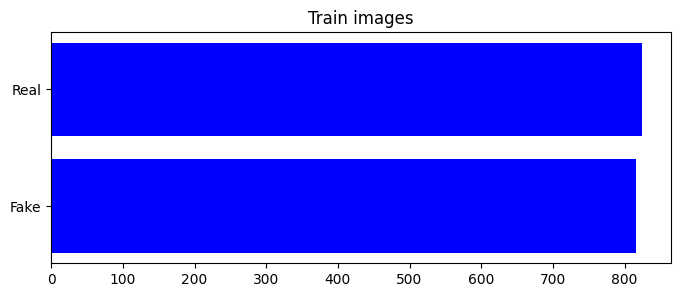

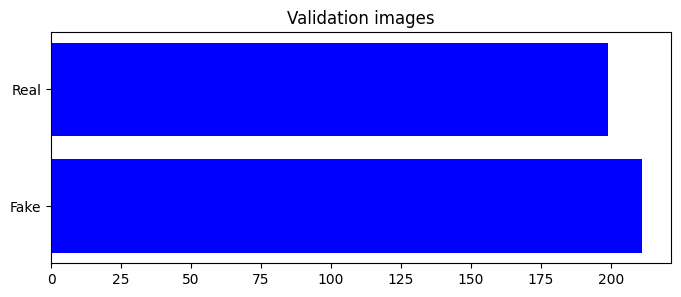

In [3]:
def plot_distribution(y, title):
    a = Counter(y)
    y = [ 'Fake', 'Real']

    x = [a[i] for i in range(2)]
    plt.figure(figsize=(8, 3))
    plt.barh(y, x, color='blue')
    plt.title(title)
    return plt.show()


y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title="Validation images")

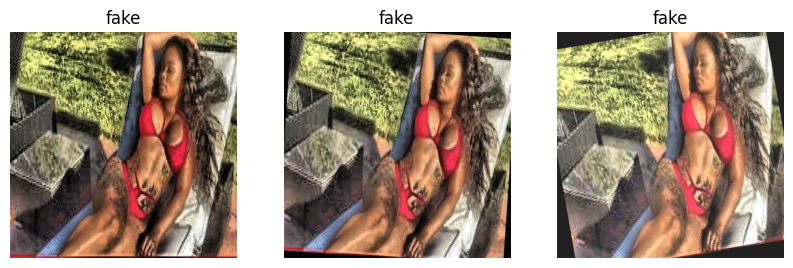

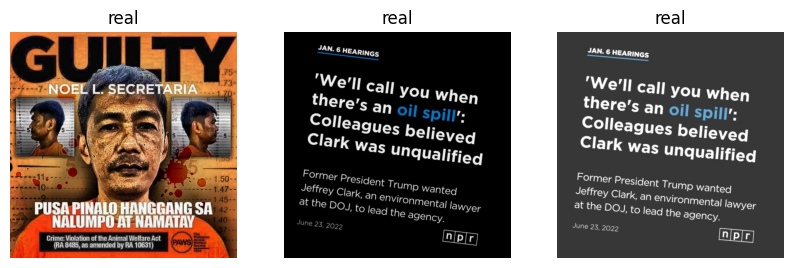

In [4]:
# Sample images
class_names = train_ds.class_names

for class_name in class_names:
    imgs = os.listdir(os.path.join(data_dir, class_name))[:3]
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(os.path.join(data_dir, class_name, img)))
        plt.title(class_name)
        plt.axis('off')

# Model Training

In [5]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models

num_classes = 2


base_model = ResNet101(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))


base_model.trainable = False


model = models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Rescaling(1./255),

    base_model,

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      min_delta=0.0001,
                                                      patience=5,
                                                      restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=[earlystop_callback])


Epoch 1/20
54/54 [==============================] - 120s 2s/step - loss: 0.4772 - accuracy: 0.8484 - val_loss: 0.2941 - val_accuracy: 0.8923
Epoch 2/20
54/54 [==============================] - 136s 3s/step - loss: 0.2310 - accuracy: 0.9105 - val_loss: 0.2105 - val_accuracy: 0.9058
Epoch 3/20
54/54 [==============================] - 140s 3s/step - loss: 0.1857 - accuracy: 0.9270 - val_loss: 0.1832 - val_accuracy: 0.9186
Epoch 4/20
54/54 [==============================] - 150s 3s/step - loss: 0.1628 - accuracy: 0.9350 - val_loss: 0.1734 - val_accuracy: 0.9210
Epoch 5/20
54/54 [==============================] - 156s 3s/step - loss: 0.1452 - accuracy: 0.9421 - val_loss: 0.1622 - val_accuracy: 0.9281
Epoch 6/20
54/54 [==============================] - 161s 3s/step - loss: 0.1301 - accuracy: 0.9468 - val_loss: 0.1506 - val_accuracy: 0.9305
Epoch 7/20
54/54 [==============================] - 166s 3s/step - loss: 0.1189 - accuracy: 0.9500 - val_loss: 0.1470 - val_accuracy: 0.9305
Epoch 8/20
5

# Model Evaluation

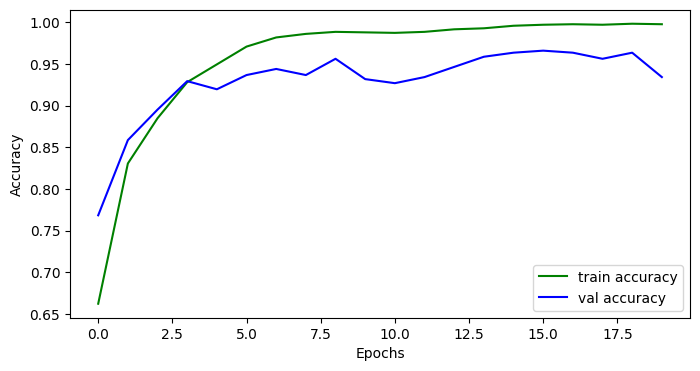

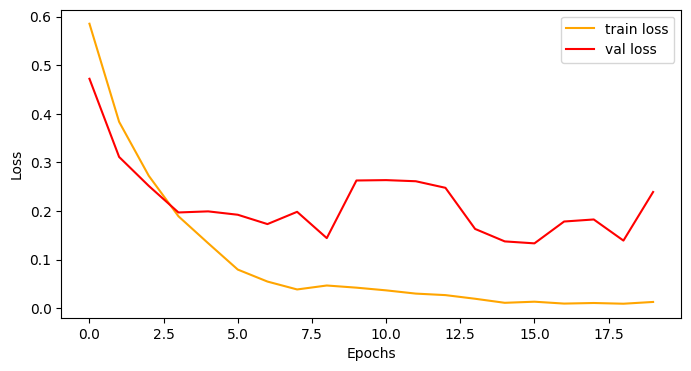

In [11]:

train_loss = history.history['loss']

train_acc = history.history['accuracy']

valid_loss = history.history['val_loss']

valid_acc = history.history['val_accuracy']


# Accuracy plots

plt.figure(figsize=(8, 4))

plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')

plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()

plt.show()


# loss plots

plt.figure(figsize=(8, 4))

plt.plot(train_loss, color='orange', linestyle='-', label='train loss')

plt.plot(valid_loss, color='red', linestyle='-', label='val loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()

plt.show()

In [12]:

loss, acc = model.evaluate(val_ds, batch_size=batch_size)

print("validation accuracy :", round(acc, 2))

print("validation loss :", round(loss, 2))

13/13 [==============================] - 1s 47ms/step - loss: 0.2392 - accuracy: 0.9341
validation accuracy : 0.93
validation loss : 0.24


In [13]:

y_pred = []  # store predicted labels

y_true = []  # store true labels


# iterate over the dataset

for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis=- 1))


# convert the true and predicted labels into tensors

correct_labels = tf.concat([item for item in y_true], axis=0)

predicted_labels = tf.concat([item for item in y_pred], axis=0)

1/1 [==============================] - 0s 106ms/step


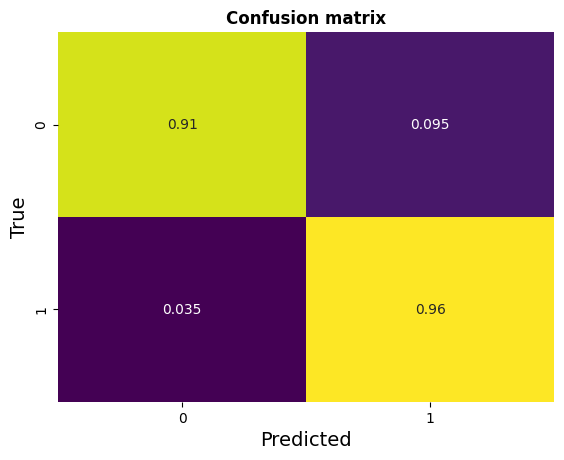

In [14]:

cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')

sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)

plt.title("Confusion matrix", fontweight='bold')

plt.ylabel("True", fontsize=14)

plt.xlabel("Predicted", fontsize=14)

plt.show()

In [15]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       211
           1       0.91      0.96      0.93       199

    accuracy                           0.93       410
   macro avg       0.94      0.94      0.93       410
weighted avg       0.94      0.93      0.93       410



# Post Processing

In [17]:
# Save
model.save("model_v1.h5")

In [10]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
img_height = 128
img_width = 128
# Load the model
model = load_model("model_v1.h5")
def prediction(img):
    class_names = ['Fake', 'Real']

    my_image = load_img(img, target_size=(img_height, img_width))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, 0)

    out = np.round(model.predict(my_image)[0], 2)
    fig = plt.figure(figsize=(7, 4))
    plt.barh(class_names, out, color='lightgray',
             edgecolor='red', linewidth=1, height=0.5)

    for index, value in enumerate(out):
        plt.text(value/2 + 0.1, index, f"{100*value:.2f}%", fontweight='bold')

    plt.xticks([])
    plt.yticks([0, 1], labels=class_names, fontweight='bold', fontsize=14)
    fig.savefig('pred_img.png', bbox_inches='tight')
    return plt.show()

1/1 [==============================] - 0s 84ms/step


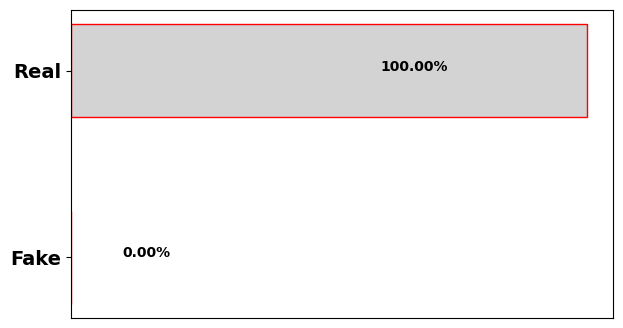

In [11]:
# Prediction on single Image
img = 'checks.jpg'
prediction(img)